# 基于泊松分布量化分析网关前置限流的限流`QPS`偏差比例

- 关于『网关前置限流分析想要解决的问题』的说明与讨论，参见 `README.md`。
- 关于泊松分布，参见 [Notebook 泊松分布的简介、代码实现与概率分布图像](poisson_intro.ipynb)。

泊松分布的概率分布/概率质量函数的实现：

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.special as sc


def poisson(lmd, k, exact=False):
    """
    泊松分布
    :param lmd: 泊松分布的 λ 参数（向量/标量）。
                对应限流问题的『单机收到的`QPS`』（压测发出的`QPS`实际上是平均值/期望）
    :param k: 观察到的次数，随机变量（向量/标量），函数返回的是 X = k次 时概率
              关联的是 限流问题中的『单机限流`QPS`』；X > 单机的限流`QPS`时，即出现限流。
    :param exact: `factorial`运算时是否`exact`
    :return: poisson(λ, k)的概率值（向量/标量）
              与 限流问题中的『限流比率』 相关，具体关系，在下面Cell中展开说明
    """
    return np.exp(-lmd) * np.power(lmd, k) / sc.factorial(k, exact=exact)

# 1. 求解的限流问题说明

已知量 |  代号
:------- | --------
流量`QPS` / 接收到的`QPS`（$RecivedQPS$，是`QPS`平均值）| $\lambda$
业务`QPS` / 业务峰值`QPS`($BizQps$) | $B$
限流`QPS`阈值 | $K$

要计算求出 

求解量 |  代号
:------- | --------
**限流`QPS`偏差比例** | $LimitedQpsErrorRatio$

### 关于『限流`QPS`偏差（比例）』

关于 偏差的正负

- 阈值设置了10 `QPS`，在小流量（流量不到10 `QPS`，如5 `QPS`）时，
    - 如果实际通过`QPS`不到5，则是限流多了（期望通过10），**偏差为正**。
- 阈值设置了10 `QPS`，在大流量时（大于10 `QPS`），
    - 如果实际通过`QPS`不到10，则是限流多了（期望通过10），**偏差为正**。
    - 如果实际通过`QPS`多于10，则是限流少了（期望通过10），**偏差为负**。
- 对应的**大家平时的说法**：
    - 对于正的偏差，即限流多了：
        - **提前限流**
    - 对于负的偏差，限流少了：
        - **没限住**
        - **多漏了流量**

公式推导，参见 [Notebook 基于泊松分布量化分析网关前置限流所需要的公式推导与代码实现](gateway_flow_limiter_formula_base_poisson.ipynb)。

限流比例 / 限流`QPS`偏差比例 的 函数实现：

In [2]:
def limited_qps(lmd, K, exact=False):
    """
    限流`QPS`

    :param lmd: 泊松分布的 λ 参数（标量）
                对应 限流问题中的流量`QPS`
    :param K: 限流`QPS`阈值（标量）
    :param exact: `factorial`运算时是否`exact`
    :return: 返回限流`QPS`（标量）
    """
    # np.arange(m, n) = [m, n), aka. np.arange(0, K) = [0, K - 1]
    ks = np.arange(0, K)
    return lmd - K + (
        # 点积/内积：dot method, or @ operator
        (K - ks) @ poisson(lmd, ks, exact=exact)
    )


def limited_ratio(lmd, K, exact=False):
    """
    限流比例

    :param lmd: 泊松分布的 λ 参数（标量）
                对应 限流问题中的流量`QPS`
    :param K: 限流`QPS`阈值（标量）
    :param exact: `factorial`运算时是否`exact`
    :return: 返回限流比例（标量）
    """
    return limited_qps(lmd, K, exact=exact) / lmd


def limited_ratio_vector(lmd_vec, K, exact=False):
    """
    限流比例
    
    :param lmd_vec: 泊松分布的 λ 参数（向量）
                    对应 限流问题中的流量`QPS`
    :param K: 限流`QPS`阈值
    :param exact: `factorial`运算时是否`exact`
    :return: 返回限流比例（向量/标量）
    """
    #def partial_limited_ratio(lmd):
    #    return limited_ratio(lmd, K, exact=False)

    #return np.vectorize(partial_limited_ratio)
    return [limited_ratio(lmd, K, exact=exact) for lmd in lmd_vec]


def pass_qps(lmd, K, exact=False):
    ks = np.arange(0, K)
    return K - (K - ks) @ poisson(lmd, ks, exact=exact)


def ideal_pass_qps(lmd, B):
    return np.minimum(lmd, B)


def limited_qps_error_ratio(lmd, K, B=None, trunkTo0=True, exact=False):
    B = K if B is None else B
    m = ideal_pass_qps(lmd, B)
    ratio = (m - pass_qps(lmd, K, exact=exact)) / m
    return np.maximum(0, ratio) if trunkTo0 else ratio


def limited_qps_error_ratio_vector(lmd_vec, K, B=None, trunkTo0=False, exact=False):
    B = K if B is None else B
    return [limited_qps_error_ratio(lmd, K, B, trunkTo0=trunkTo0, exact=exact) for lmd in lmd_vec]

# 2. 限流`QPS`偏差比例 的分布图像

## 2.1 给定限流`QPS`阈值$K$与业务`QPS`$B$下， 限流`QPS`偏差比例 与 流量`QPS`($\lambda$) 的关系

为了避免数据比例差异过大、小比例的部分图像被压扁而不能有效查看，分成2情况绘制函数图像：

- 限流`QPS`阈值 $K <= 20$
- 限流`QPS`阈值 $K >= 20$

### 2.1.1 限流`QPS`阈值 $K <= 20$，业务`QPS`$B = K$（即放大比例 $R = 1$）

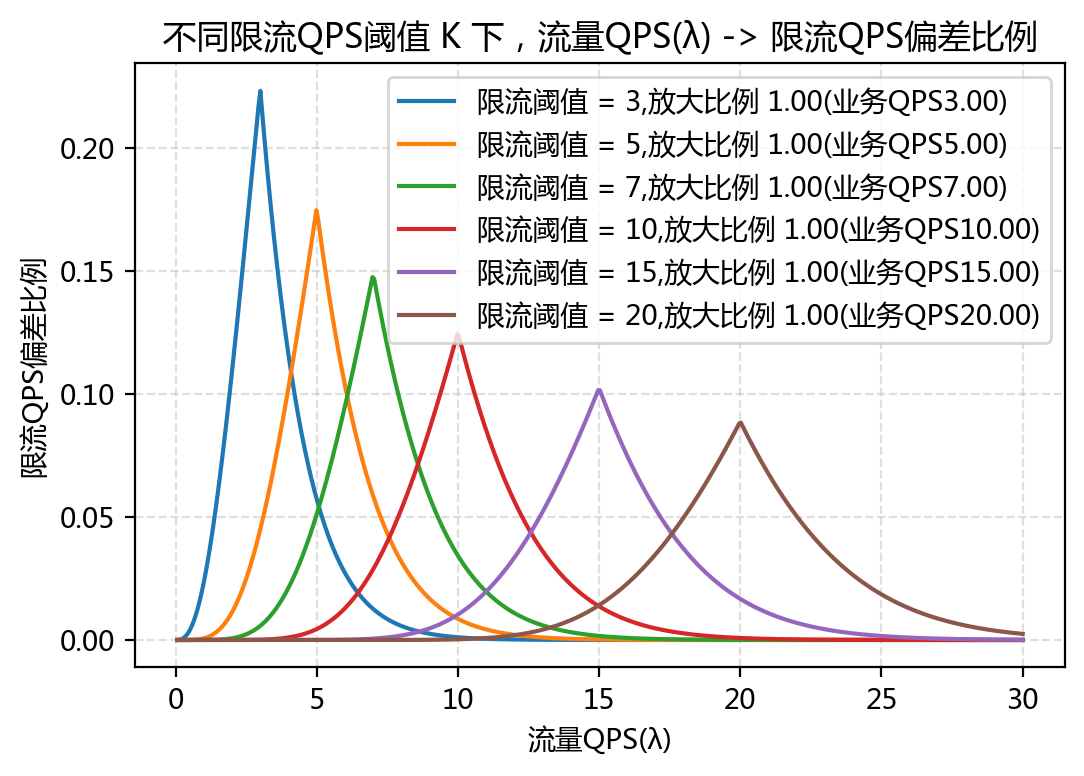

In [3]:
def plot_limited_qps_error_ratio(x, K, B=None, trunkTo0=False):
    B = K if B is None else B
    plt.plot(x, limited_qps_error_ratio_vector(lmd_vec=x, K=K, B=B, trunkTo0=trunkTo0), label=f"限流阈值 = {K},放大比例{K/B : .2f}(业务QPS{B:.2f})")


def batch_plot_limited_qps_error_ratio(x, ks, r=1, trunkTo0=False):
    for k in ks:
        plot_limited_qps_error_ratio(x, K=k, B = k / r, trunkTo0=trunkTo0)


plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200

batch_plot_limited_qps_error_ratio(
    np.linspace(0, 30, 500)[1:],
    [3, 5, 7, 10, 15, 20]
)

plt.xlabel('流量QPS(λ)')
plt.ylabel('限流QPS偏差比例')

plt.grid(alpha=.4, linestyle='--')

plt.title("不同限流QPS阈值 K 下，流量QPS(λ) -> 限流QPS偏差比例")

plt.legend()

plt.show()

### 2.1.2 限流`QPS`阈值 $K >= 20$，业务`QPS`$B = K$（即放大比例 $R = 1$）

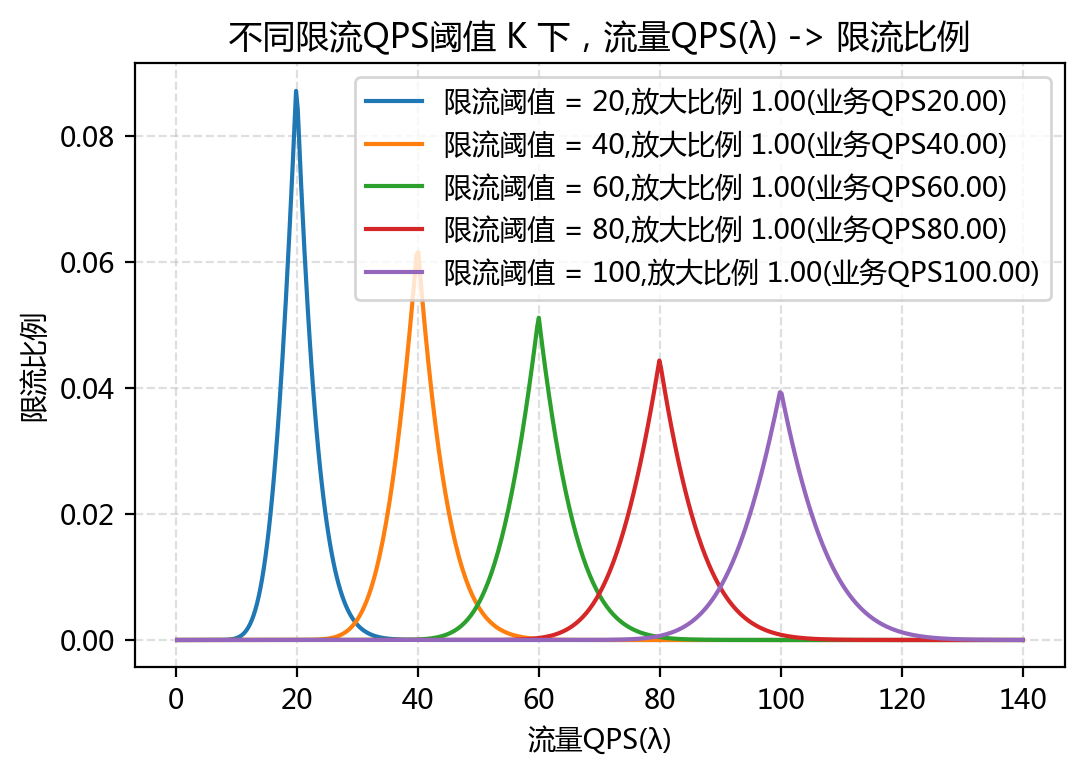

In [4]:
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200

batch_plot_limited_qps_error_ratio(
    np.linspace(0, 140, 500)[1:],
    [20, 40, 60, 80, 100]
)

plt.xlabel('流量QPS(λ)')
plt.ylabel('限流比例')

plt.grid(alpha=.4, linestyle='--')

plt.title("不同限流QPS阈值 K 下，流量QPS(λ) -> 限流比例")

plt.legend()

plt.show()

### 2.1.3 显然，**限流`QPS`偏差比例**

- 当 流量`QPS` 等于 限流`QPS`阈值时（$\lambda = K$）时，正的限流`QPS`偏差比例最大。
- 在最大值的两侧：
    - **随 流量`QPS`($\lambda$) 增加 ，单调递减。**    
        .    
    - ${\lim\limits_{\lambda \to +\infty}} LimitedQpsErrorRatio(\lambda, K) = 0$  
        .
    - **随 流量`QPS`($\lambda$) 减少 ，单调递减。**    
        .    
    - ${\lim\limits_{\lambda \to +0}} LimitedQpsErrorRatio(\lambda, K) = 0$  
        .
- **随 限流`QPS`阈值 $K$ ，单调递减。**     
    .    
- ${\lim\limits_{K \to +\infty}} LimitedQpsErrorRatio(\lambda, K) = 0$

## 2.2 通过调整放大比例$R$ 平衡 限流`QPS`偏差比例

如果用『放大比例』来表述，限流`QPS`阈值 $K$ 由 业务`QPS` $B$（$K = B * R$） 被动决定的。

- 『放大比例』是 实现方式。
- 下面这些『放大比例』的图**_内部（非面向用户）_**了解。

下面查看 给定『放大比例』下， 限流比例 与 流量`QPS`($\lambda$) / 限流`QPS`阈值 $K$ 的关系

### 2.2.1 限流`QPS`阈值 $K <= 20$，业务`QPS`$B = K / 1.2$（放大比例 $R = 1.2$）

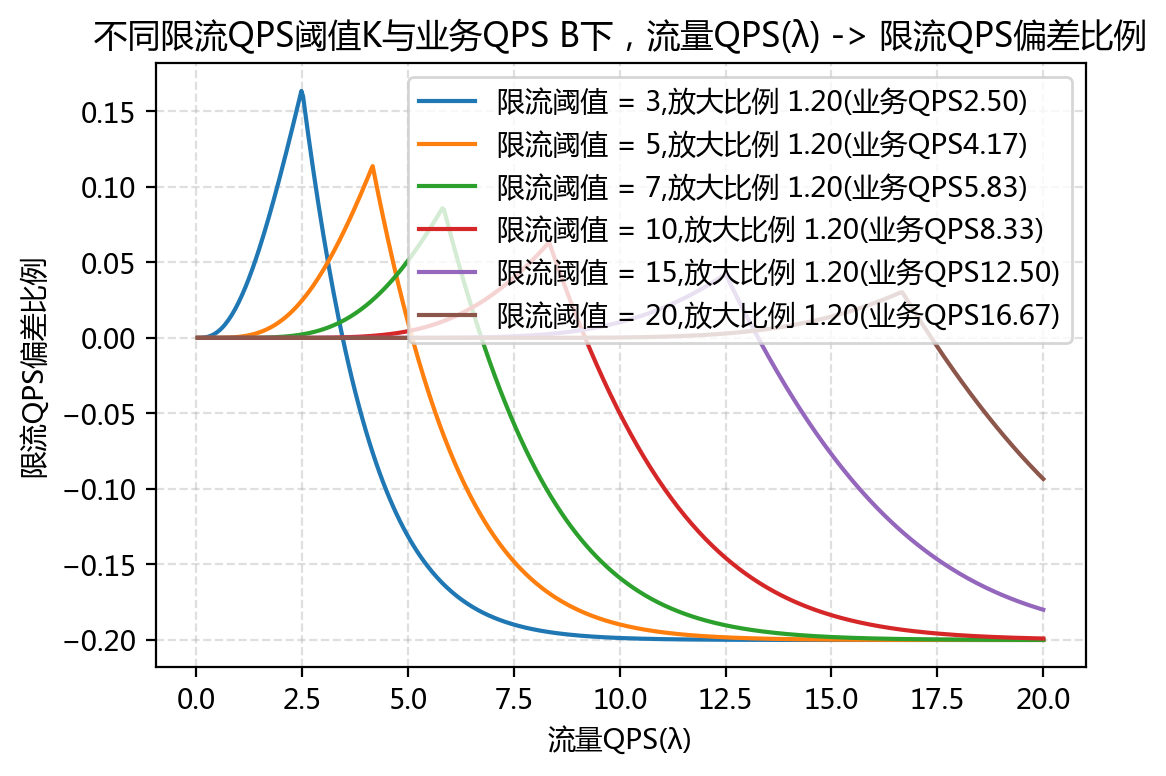

In [5]:
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200

batch_plot_limited_qps_error_ratio(
    np.linspace(0, 20, 500)[1:],
    [3, 5, 7, 10, 15, 20],
    r = 1.2
)

plt.xlabel('流量QPS(λ)')
plt.ylabel('限流QPS偏差比例')

plt.grid(alpha=.4, linestyle='--')

plt.title("不同限流QPS阈值K与业务QPS B下，流量QPS(λ) -> 限流QPS偏差比例")

plt.legend()

plt.show()

#### 为了方便查看正值部分，把负值Trunk成0。

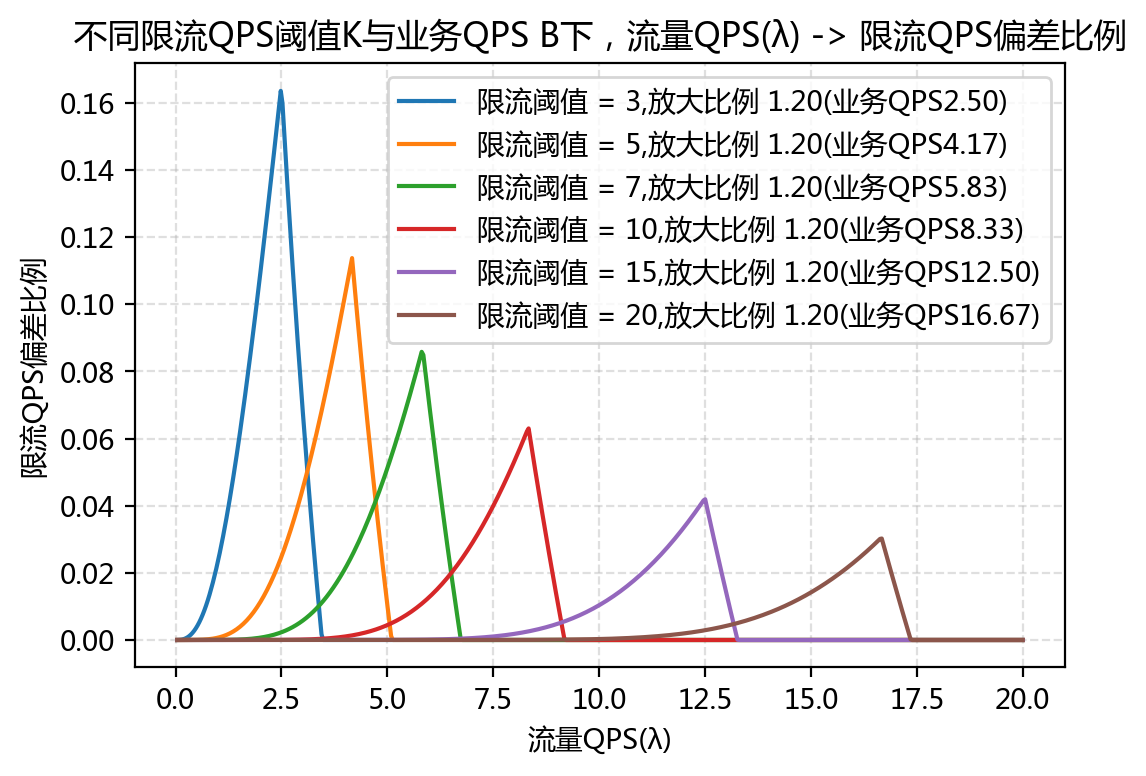

In [6]:
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200

batch_plot_limited_qps_error_ratio(
    np.linspace(0, 20, 500)[1:],
    [3, 5, 7, 10, 15, 20],
    r = 1.2, trunkTo0=True
)

plt.xlabel('流量QPS(λ)')
plt.ylabel('限流QPS偏差比例')

plt.grid(alpha=.4, linestyle='--')

plt.title("不同限流QPS阈值K与业务QPS B下，流量QPS(λ) -> 限流QPS偏差比例")

plt.legend()

plt.show()

### 2.2.2 限流`QPS`阈值 $K >= 20$，业务`QPS`$B = K / 1.2$（放大比例 $R = 1.2$）

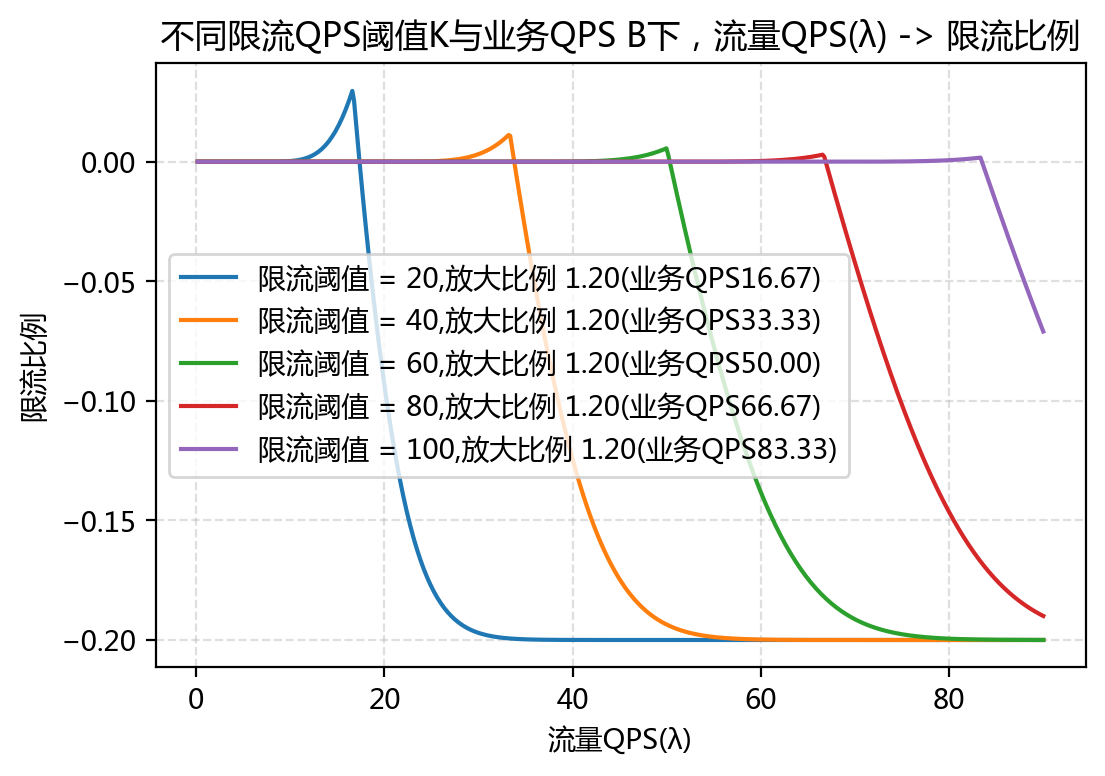

In [7]:
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200

batch_plot_limited_qps_error_ratio(
    np.linspace(0, 90, 500)[1:],
    [20, 40, 60, 80, 100],
    r = 1.2
)

plt.xlabel('流量QPS(λ)')
plt.ylabel('限流比例')

plt.grid(alpha=.4, linestyle='--')

plt.title("不同限流QPS阈值K与业务QPS B下，流量QPS(λ) -> 限流比例")

plt.legend()

plt.show()

#### 为了方便查看正值部分，把负值Trunk成0。

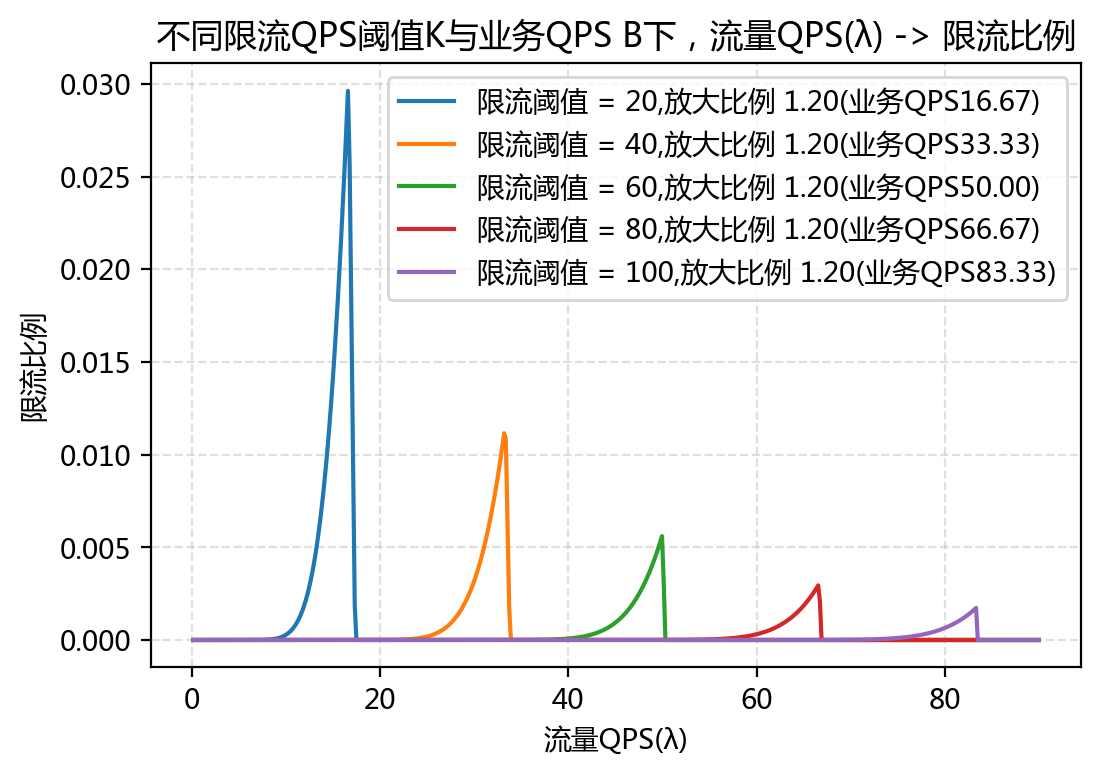

In [8]:
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200

batch_plot_limited_qps_error_ratio(
    np.linspace(0, 90, 500)[1:],
    [20, 40, 60, 80, 100],
    r = 1.2, trunkTo0=True
)

plt.xlabel('流量QPS(λ)')
plt.ylabel('限流比例')

plt.grid(alpha=.4, linestyle='--')

plt.title("不同限流QPS阈值K与业务QPS B下，流量QPS(λ) -> 限流比例")

plt.legend()

plt.show()

### 2.2.3 显然，对于放大比例$R$时（$B = K / R$），**限流`QPS`偏差比例**

- 当 流量`QPS` 等于 业务`QPS`时（$\lambda = B$）时，正的限流`QPS`偏差比例最大。
- 在最大值的两侧：
    - **随 流量`QPS`($\lambda$) 增加 ，单调递减。**    
        .    
    - ${\lim\limits_{\lambda \to +\infty}} LimitedQpsErrorRatio(\lambda, K) = 1 - R$   
        .
    - **随 流量`QPS`($\lambda$) 减少 ，单调递减。**    
        .    
    - ${\lim\limits_{\lambda \to +0}} LimitedQpsErrorRatio(\lambda, K) = 0$

### 最小限流`QPS`偏差比例，或说 负的最大限流`QPS`偏差比例

$$
\begin{aligned}
MinLimitedQpsErrorRatio(B, K) &=
MinLimitedQpsErrorRatio(B, B * R)
\\&=
1 - R
\end{aligned}
\tag{2.1}
$$

举些例子方便更有体感：

放大比例$R$ | 含义 | 最大 **负的**限流比例
:--------- | ------ | ---------
1.2 | 最高通过2倍的业务`QPS` | -20%
2 | 最高通过2倍的业务`QPS` | -100%
3 | 最高通过3倍的业务`QPS` | -200%

### 最大限流`QPS`偏差比例，或说 最大提前限流`QPS`偏差比例

$$
\begin{aligned}
MaxLimitedQpsErrorRatio(B, K) &=
LimitedQpsErrorRatio(B, B, K)
\end{aligned}
\tag{2.2}
$$

### 最大提前限流`QPS`偏差比例的代码实现

In [9]:
def B_r_to_max_limited_qps_error_ratio(B, r=1):
    return limited_qps_error_ratio(lmd=B, K=B * r, B=B)


def B_vec_r_to_max_limited_qps_error_ratio(B_vec, r=1):
    return [B_r_to_max_limited_qps_error_ratio(B, r=r) for B in B_vec]


def B_r_vec_to_max_limited_qps_error_ratio(B, r_vec):
    return [B_r_to_max_limited_qps_error_ratio(B, r=r) for r in r_vec]

# 3. (业务`QPS` $B$, 放大比例 $R$) -> 最大 *正的*限流`QPS`偏差比例

为了避免数据比例差异过大、小比例的部分图像被压扁而不能有效查看，分成多种情况绘制函数图像：  
\# 网关大约 `5K`台机器

No.|（单机）业务`QPS` $B$ | 业务服务的`QPS`
:------- | :------------------- | ----------------
1 | 小业务`QPS` $B >= 3$ | 15K(1.5W)
2 | 中业务`QPS` $B >= 10$ | 50K(5W)
3 | 大业务`QPS` $B >= 50$ | 250K(25W)
4 | 超大业务`QPS` $B >= 100$ | 500K(50W)

## 3.1 小业务`QPS` $B >= 3$：放大比例 $R$ -> 最大限流`QPS`偏差比例

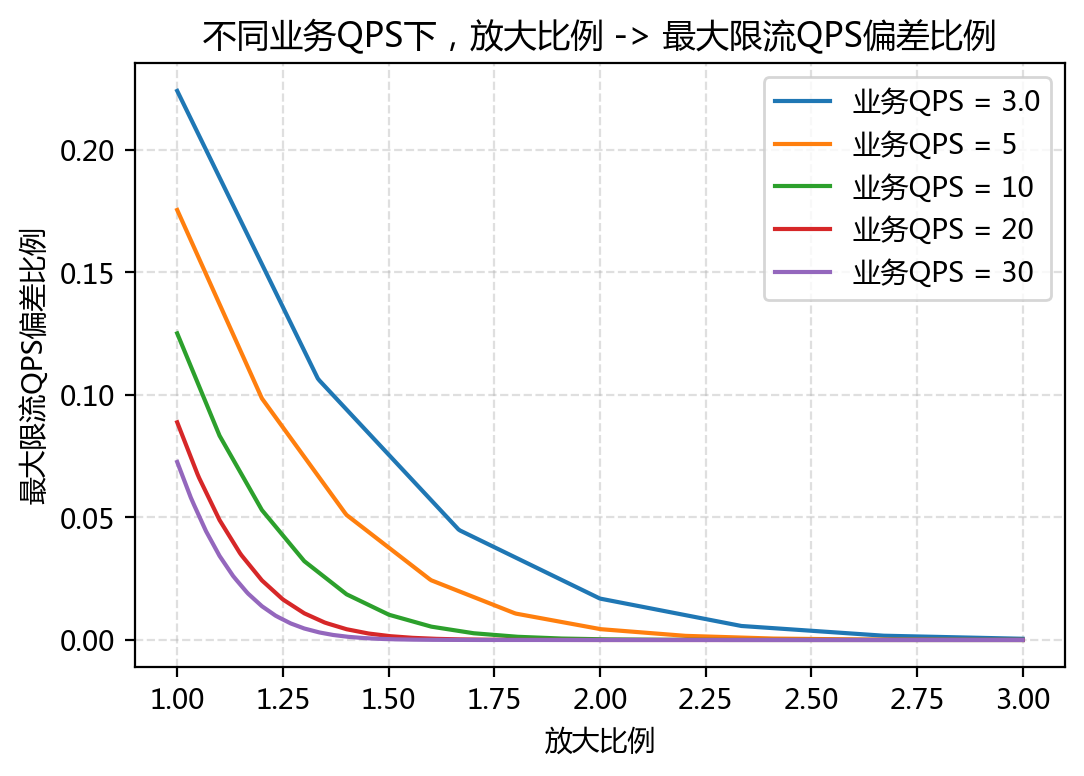

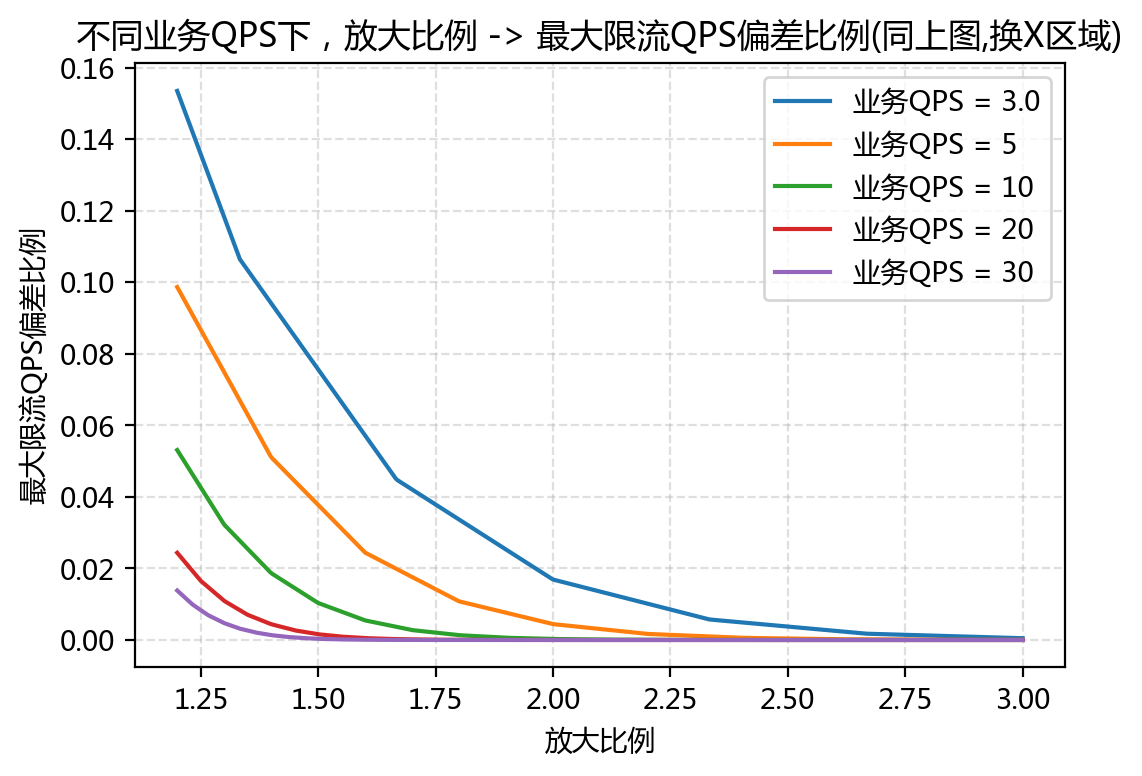

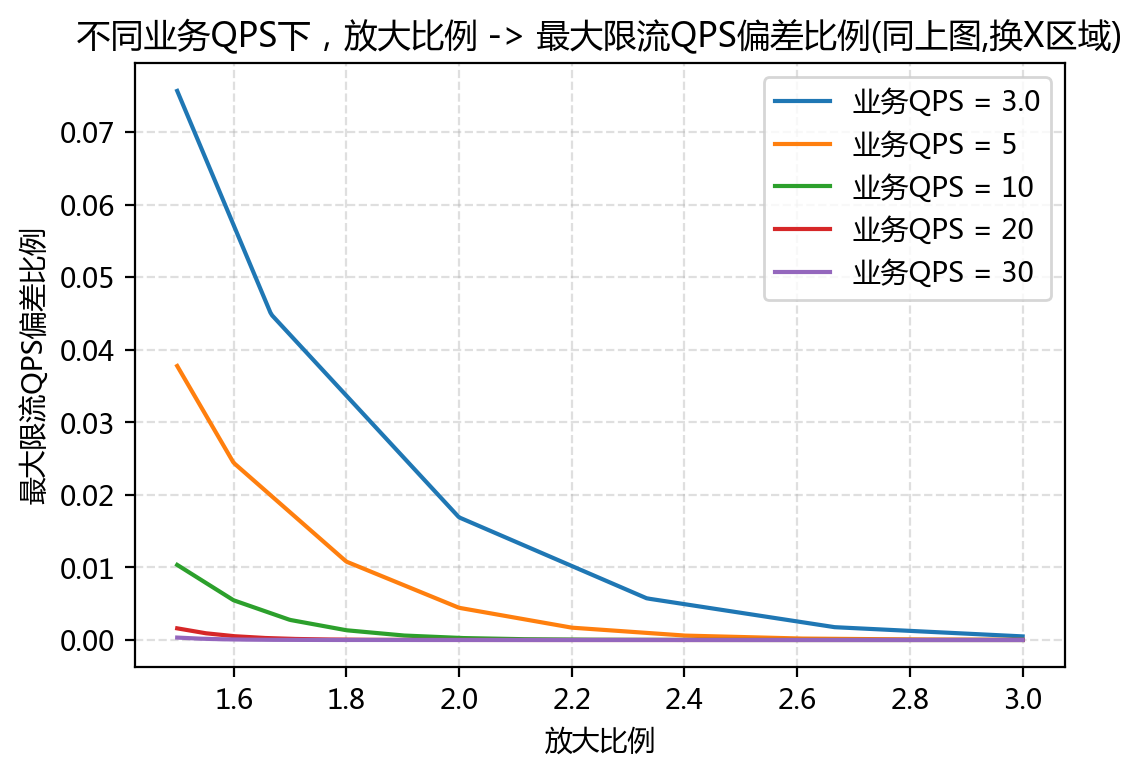

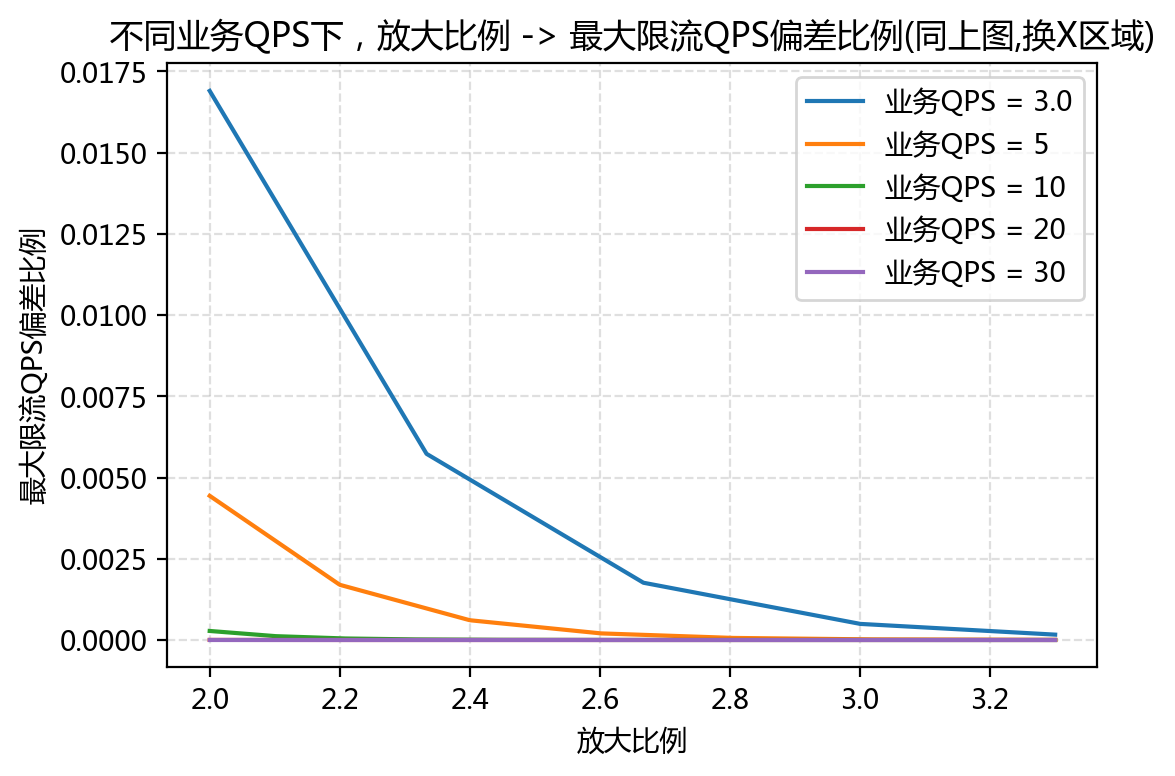

In [10]:
def plot_B_r_to_max_limited_qps_error_ratio(B, r_vec):
    plt.plot(r_vec, B_r_vec_to_max_limited_qps_error_ratio(B, r_vec), label=f"业务QPS = {B}")


def batch_plot_B_r_to_max_limited_qps_error_ratio(Bs, r_vec):
    for B in Bs:
        plot_B_r_to_max_limited_qps_error_ratio(B, r_vec)


#################


plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200

Bs=[3.0, 5, 10, 20, 30]

batch_plot_B_r_to_max_limited_qps_error_ratio(
    Bs=[3.0, 5, 10, 20, 30],
    r_vec=np.linspace(1, 3, 500)
)

plt.xlabel('放大比例')
plt.ylabel('最大限流QPS偏差比例')

plt.grid(alpha=.4, linestyle='--')

plt.title("不同业务QPS下，放大比例 -> 最大限流QPS偏差比例")

plt.legend()

plt.show()

#################

plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200

batch_plot_B_r_to_max_limited_qps_error_ratio(
    Bs=[3.0, 5, 10, 20, 30],
    r_vec=np.linspace(1.2, 3, 500)
)

plt.xlabel('放大比例')
plt.ylabel('最大限流QPS偏差比例')

plt.grid(alpha=.4, linestyle='--')

plt.title("不同业务QPS下，放大比例 -> 最大限流QPS偏差比例(同上图,换X区域)")

plt.legend()

plt.show()

#################

plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200

batch_plot_B_r_to_max_limited_qps_error_ratio(
    Bs=[3.0, 5, 10, 20, 30],
    r_vec=np.linspace(1.5, 3, 500)
)

plt.xlabel('放大比例')
plt.ylabel('最大限流QPS偏差比例')

plt.grid(alpha=.4, linestyle='--')

plt.title("不同业务QPS下，放大比例 -> 最大限流QPS偏差比例(同上图,换X区域)")

plt.legend()

plt.show()

#################

plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200

batch_plot_B_r_to_max_limited_qps_error_ratio(
    Bs=[3.0, 5, 10, 20, 30],
    r_vec=np.linspace(2, 3.3, 500)
)

plt.xlabel('放大比例')
plt.ylabel('最大限流QPS偏差比例')

plt.grid(alpha=.4, linestyle='--')

plt.title("不同业务QPS下，放大比例 -> 最大限流QPS偏差比例(同上图,换X区域)")

plt.legend()

plt.show()

## 3.2 中业务`QPS` $B >= 10$：放大比例 $R$ -> 最大限流`QPS`偏差比例

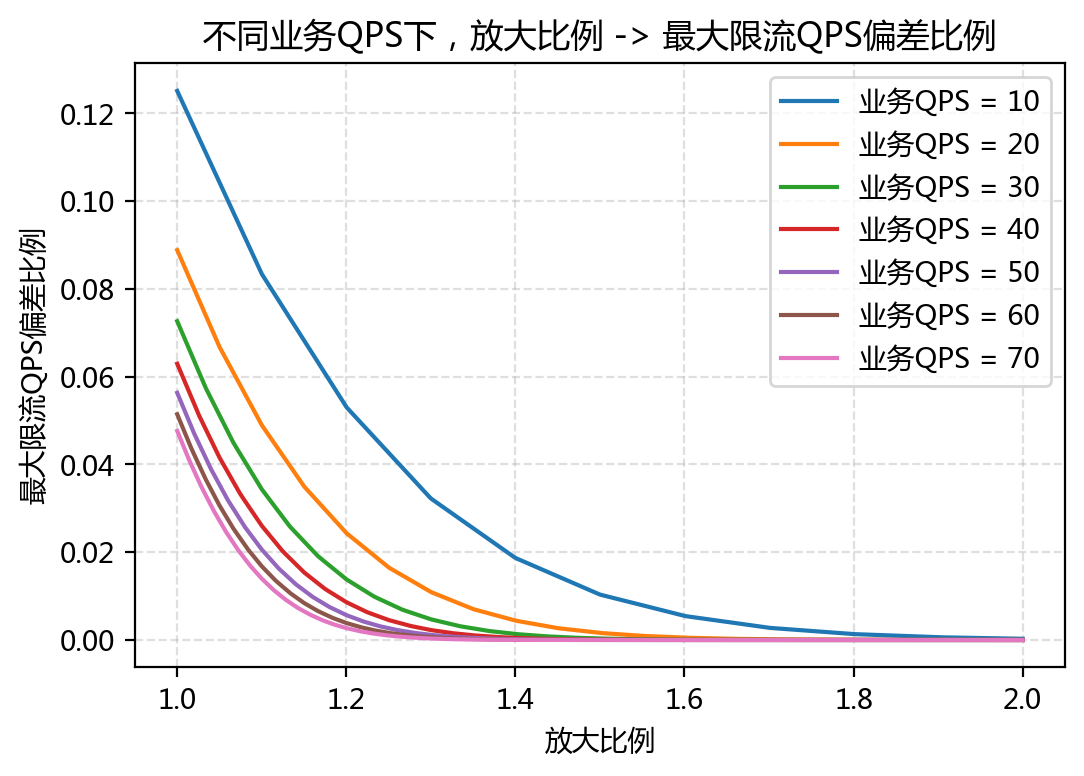

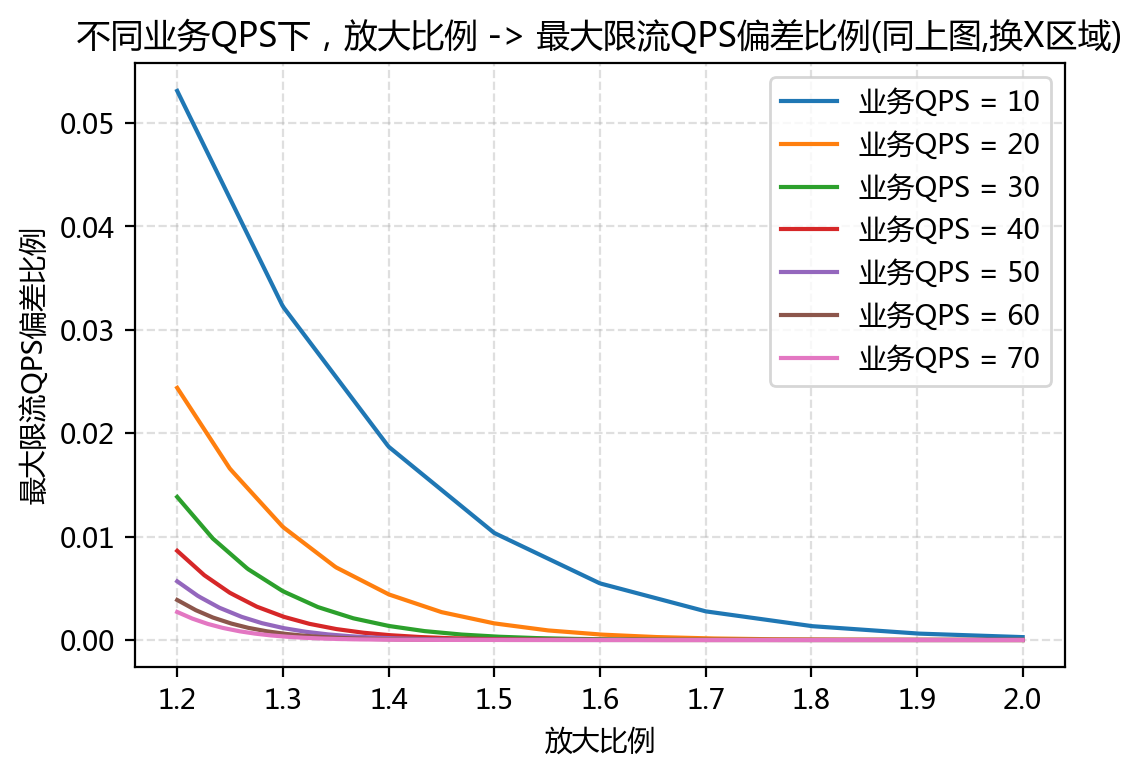

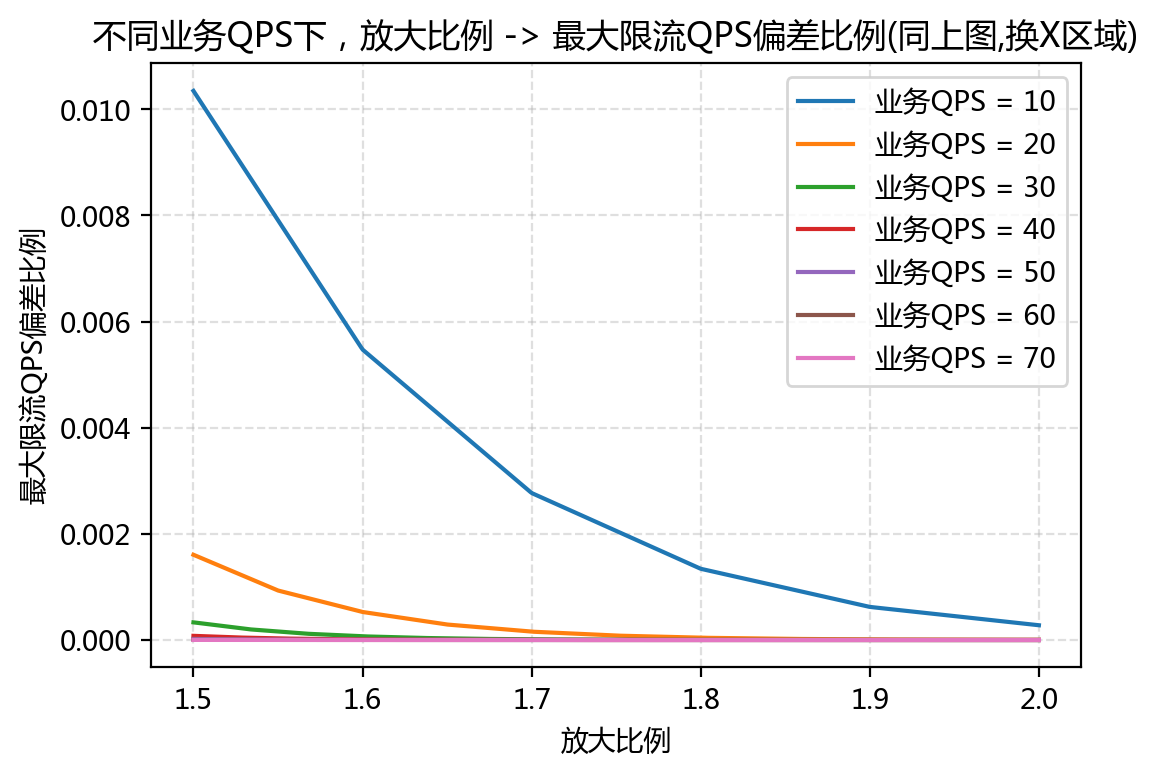

In [11]:
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200

batch_plot_B_r_to_max_limited_qps_error_ratio(
    Bs=[10, 20, 30, 40, 50, 60, 70],
    r_vec=np.linspace(1, 2, 500)
)

plt.xlabel('放大比例')
plt.ylabel('最大限流QPS偏差比例')

plt.grid(alpha=.4, linestyle='--')

plt.title("不同业务QPS下，放大比例 -> 最大限流QPS偏差比例")

plt.legend()

plt.show()

####################

plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200

batch_plot_B_r_to_max_limited_qps_error_ratio(
    Bs=[10, 20, 30, 40, 50, 60, 70],
    r_vec=np.linspace(1.2, 2, 500)
)

plt.xlabel('放大比例')
plt.ylabel('最大限流QPS偏差比例')

plt.grid(alpha=.4, linestyle='--')

plt.title("不同业务QPS下，放大比例 -> 最大限流QPS偏差比例(同上图,换X区域)")

plt.legend()

plt.show()

####################

plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200

batch_plot_B_r_to_max_limited_qps_error_ratio(
    Bs=[10, 20, 30, 40, 50, 60, 70],
    r_vec=np.linspace(1.5, 2, 500)
)

plt.xlabel('放大比例')
plt.ylabel('最大限流QPS偏差比例')

plt.grid(alpha=.4, linestyle='--')

plt.title("不同业务QPS下，放大比例 -> 最大限流QPS偏差比例(同上图,换X区域)")

plt.legend()

plt.show()

## 3.3 大业务`QPS` $B >= 50$：给定放大比例，放大比例 $R$ -> 最大限流`QPS`偏差比例

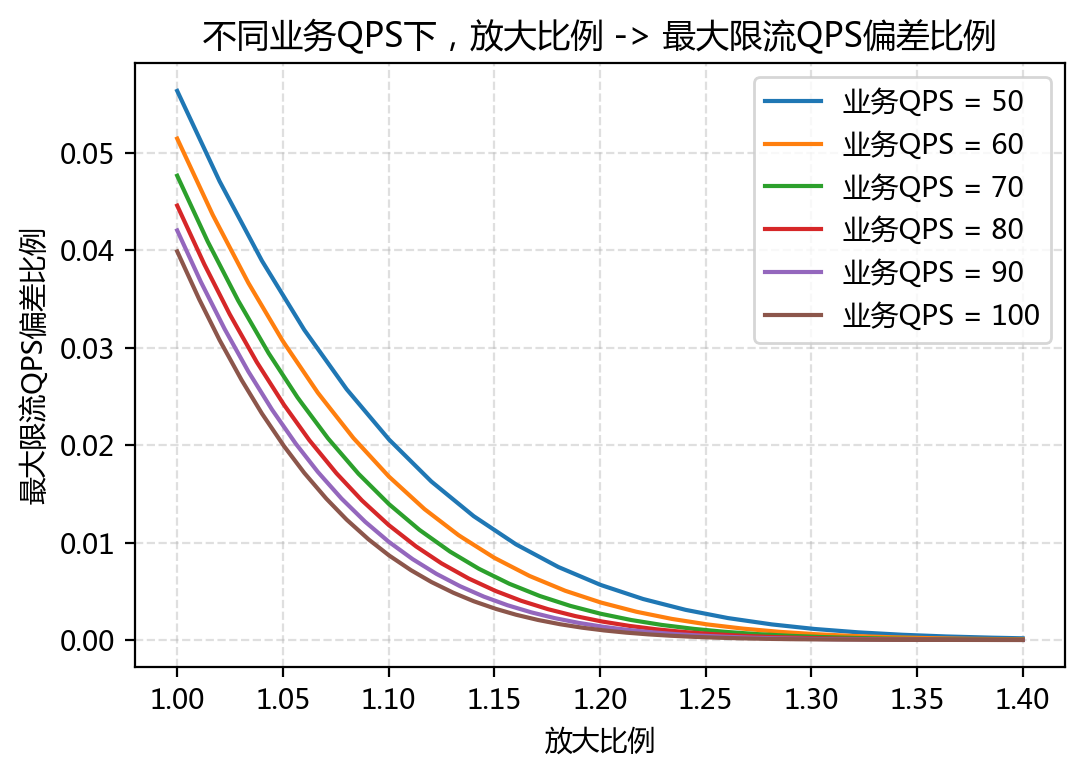

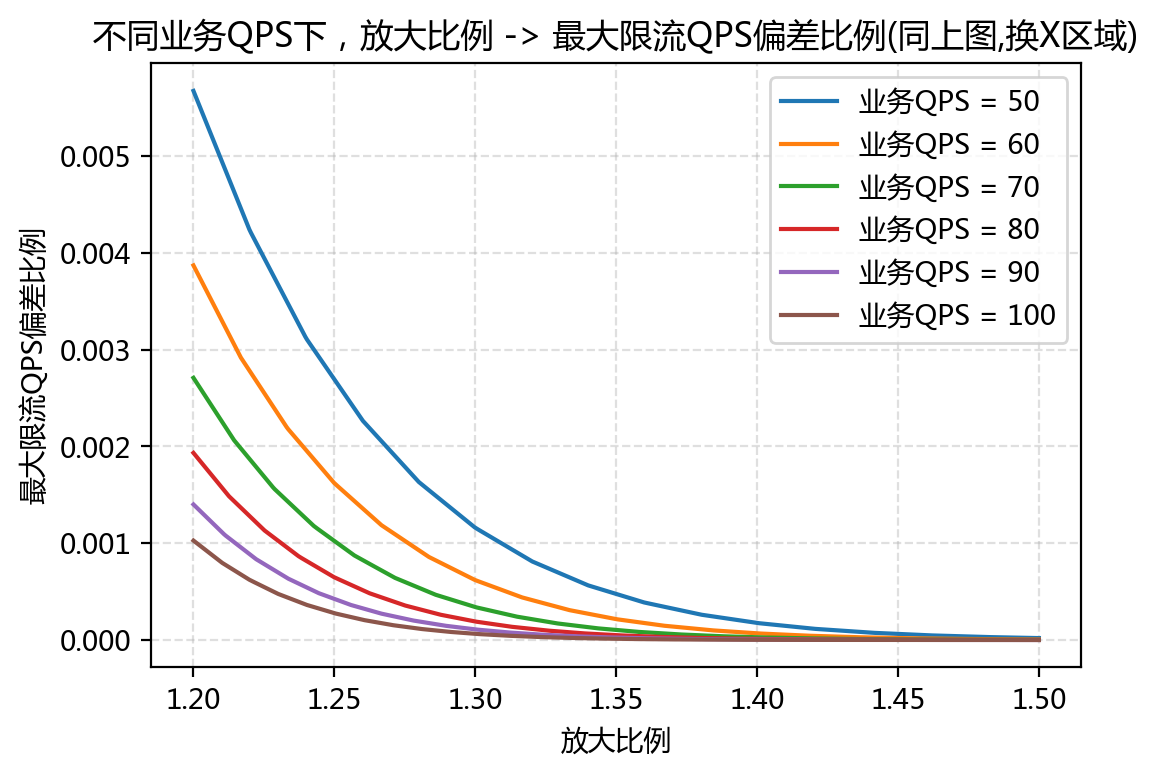

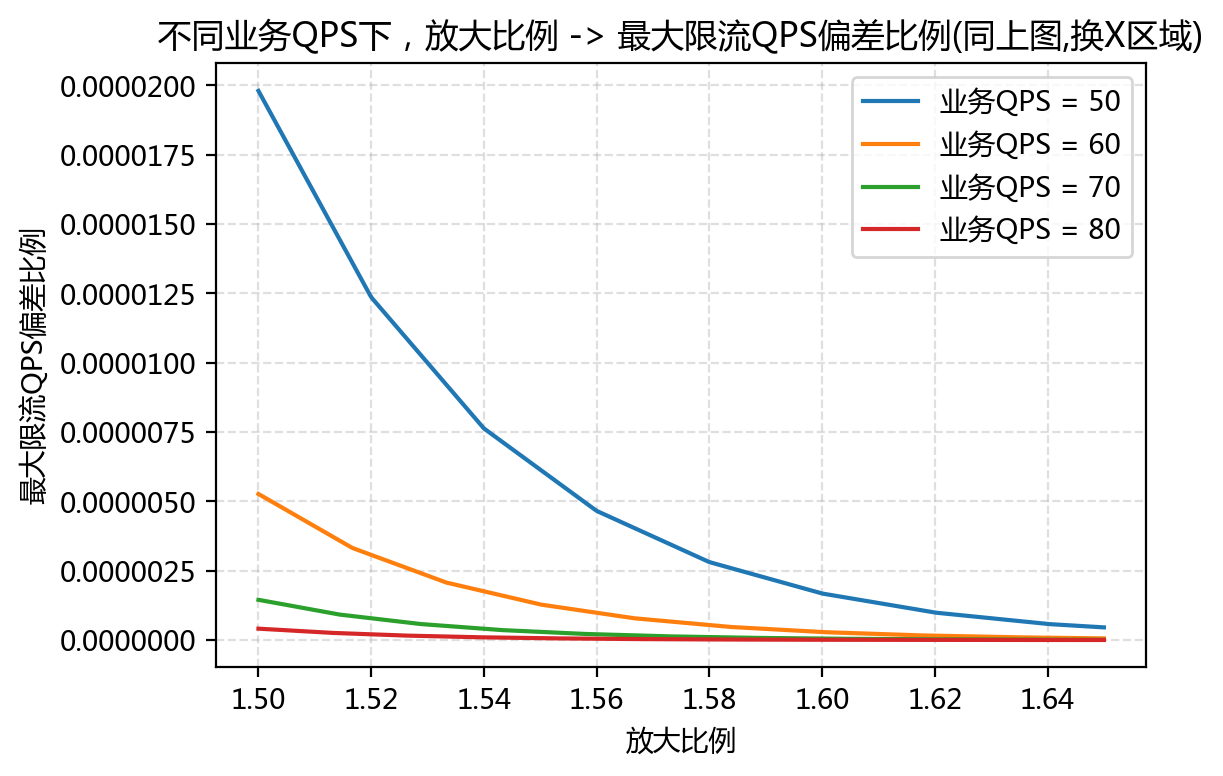

In [12]:
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200

batch_plot_B_r_to_max_limited_qps_error_ratio(
    Bs=[50, 60, 70, 80, 90, 100],
    r_vec=np.linspace(1, 1.4, 500)
)

plt.xlabel('放大比例')
plt.ylabel('最大限流QPS偏差比例')

plt.grid(alpha=.4, linestyle='--')

plt.title("不同业务QPS下，放大比例 -> 最大限流QPS偏差比例")

plt.legend()

plt.show()

################

plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200

batch_plot_B_r_to_max_limited_qps_error_ratio(
    Bs=[50, 60, 70, 80, 90, 100],
    r_vec=np.linspace(1.2, 1.5, 500)
)

plt.xlabel('放大比例')
plt.ylabel('最大限流QPS偏差比例')

plt.grid(alpha=.4, linestyle='--')

plt.title("不同业务QPS下，放大比例 -> 最大限流QPS偏差比例(同上图,换X区域)")

plt.legend()

plt.show()

################

plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200

batch_plot_B_r_to_max_limited_qps_error_ratio(
    Bs=[50, 60, 70, 80],
    r_vec=np.linspace(1.5, 1.65, 500)
)

plt.xlabel('放大比例')
plt.ylabel('最大限流QPS偏差比例')

plt.grid(alpha=.4, linestyle='--')

plt.title("不同业务QPS下，放大比例 -> 最大限流QPS偏差比例(同上图,换X区域)")

plt.legend()

plt.show()

## 3.4 大业务`QPS` $B >= 100$：放大比例 $R$ -> 最大限流`QPS`偏差比例

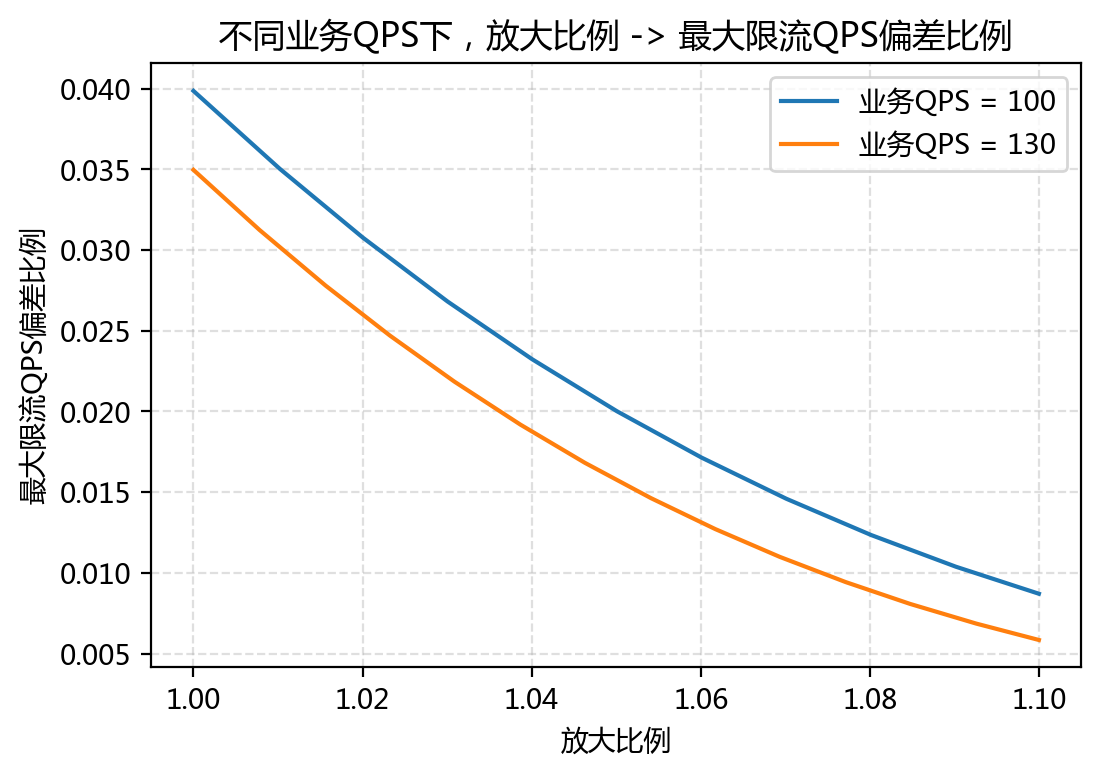

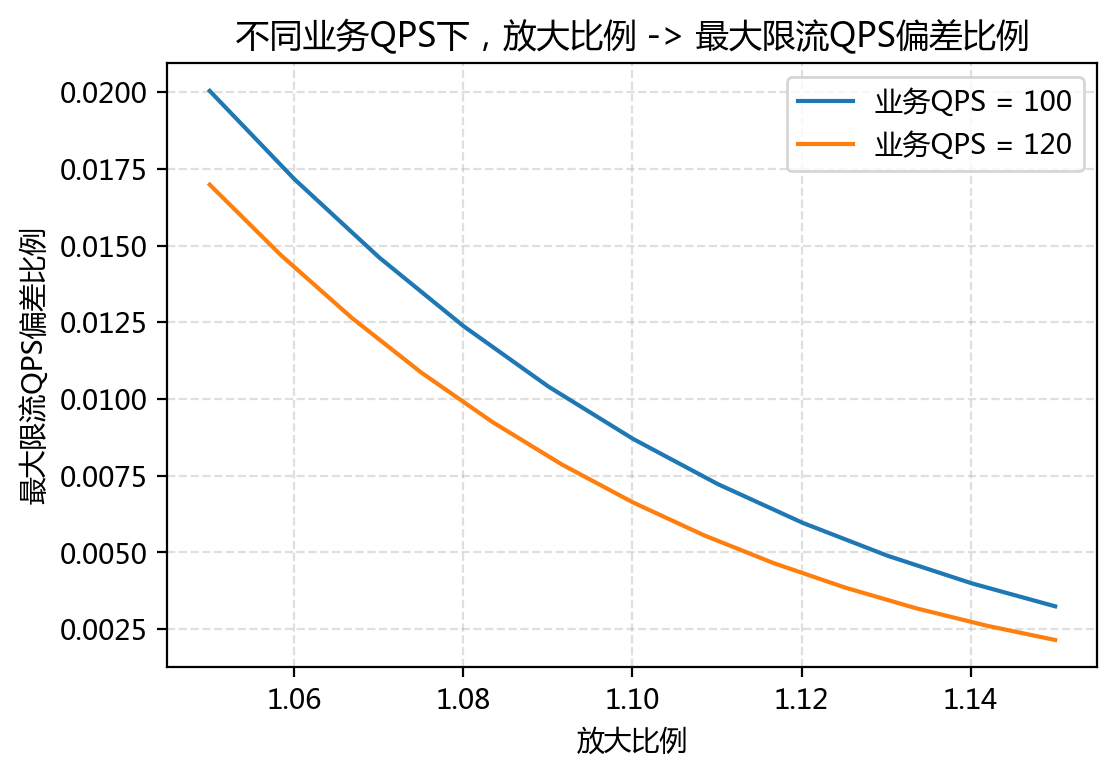

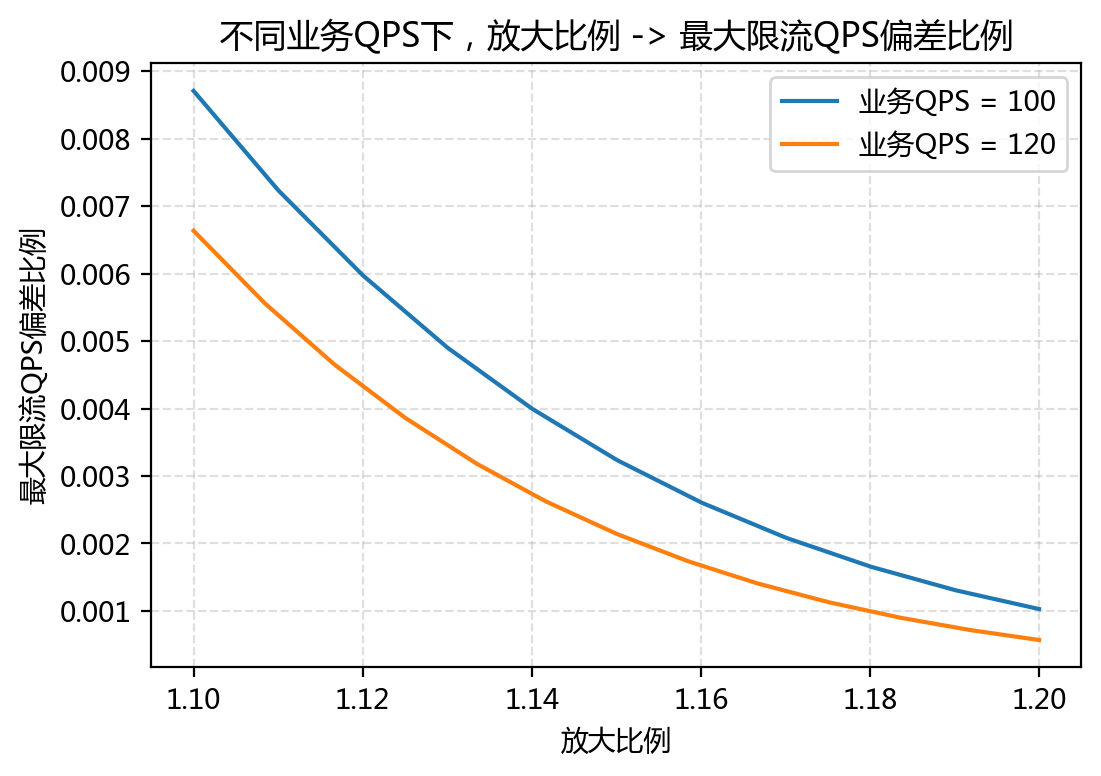

In [13]:
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200

batch_plot_B_r_to_max_limited_qps_error_ratio(
    Bs=[100, 130],
    r_vec=np.linspace(1, 1.1, 500)
)

plt.xlabel('放大比例')
plt.ylabel('最大限流QPS偏差比例')

plt.grid(alpha=.4, linestyle='--')

plt.title("不同业务QPS下，放大比例 -> 最大限流QPS偏差比例")

plt.legend()

plt.show()

################

plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200

batch_plot_B_r_to_max_limited_qps_error_ratio(
    Bs=[100, 120],
    r_vec=np.linspace(1.05, 1.15, 500)
)

plt.xlabel('放大比例')
plt.ylabel('最大限流QPS偏差比例')

plt.grid(alpha=.4, linestyle='--')

plt.title("不同业务QPS下，放大比例 -> 最大限流QPS偏差比例")

plt.legend()

plt.show()

################

plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200

batch_plot_B_r_to_max_limited_qps_error_ratio(
    Bs=[100, 120],
    r_vec=np.linspace(1.1, 1.2, 500)
)

plt.xlabel('放大比例')
plt.ylabel('最大限流QPS偏差比例')

plt.grid(alpha=.4, linestyle='--')

plt.title("不同业务QPS下，放大比例 -> 最大限流QPS偏差比例")

plt.legend()

plt.show()

## 3.5 显然，对于固定 流量`QPS`($\lambda$)

- **限流比例**，**随 放大比例，单调递减。**   
   .
- $
\begin{aligned}
{\lim\limits_{R \to +\infty}} LimitedRatio(\lambda, \lambda * R)
&= {\lim\limits_{K \to +\infty}} LimitedRatio(\lambda, K) 
\\&= 0
\end{aligned}
$

# 4. 面向技术的量化分析

### 4.1 关于 技术面的量化分析

上面 完成 了

- 在不同 
    - **流量** 
    - 与 **限流阈值**
- 下 的 限流比例，
- 在不同
    - **流量**
    - 与 **放大比例**（限流阈值 = 放大比例 * 流量）
- 下 的 （最大）限流QPS偏差比例

的 量化分析（即给出具体数值）。

但是

- 这些数值只是 事实，对技术功能的描述；即 **_面向技术_**的分析。
- 并没有结合 业务/用户的需求，没有给出业务解决方案；即 **_面向业务_**的分析。

对于 业务/用户的需求 而言，

- 用户关心的是 业务需求的需求的满足。
- 对于自己的场景，如何选择？能不能给出指导配置。
- 而不是用户并不关心 『放大比率』
    - 『放大比率』是个技术手段
    - 没有直接地表达出『对业务保障的承诺』，即『限流QPS偏差比例』。

这个些问题要从业务分析来获得。让我们进入业务分析吧～ 🕺🎶👻

# 相关资料

## 数值/科学计算

- [Factorial of a matrix elementwise with Numpy](https://stackoverflow.com/questions/30879063)
- [numpy中矩阵乘法，星乘(*)和点乘(.dot)的区别 - CSDN博客](https://blog.csdn.net/like4501/article/details/79753346)

## 工具问题

- 绘图
    - [Matplotlib的中文字体显示为方块的问题 - CSDN博客](https://blog.csdn.net/g11d111/article/details/77600114)
    - [Python绘图问题：Matplotlib中指定图片大小和像素](https://blog.csdn.net/weixin_34613450/article/details/80678522)
- 展示
    - [Jupyter Notebook: Markdown+LaTeX - CSDN博客](https://blog.csdn.net/z583636762/article/details/79167130)
- IDE `PyCharm`
    - [How to bind multiple actions to a shortcut - Stack Overflow](https://stackoverflow.com/questions/32948061/how-to-bind-multiple-actions-to-a-shortcut)
    
## LaTeX

- [一份其实很短的 LaTeX 入门文档](https://liam.page/2014/09/08/latex-introduction/)
- [Latex 公式换行问题（换行，等号对齐）- CSDN博客](https://blog.csdn.net/leichaoaizhaojie/article/details/53463598)
- [Markdown下LaTeX公式、编号、对齐 - 作业部落 Cmd Markdown 编辑阅读器](https://www.zybuluo.com/fyywy520/note/82980)
- [LaTeX技巧108：求和、LaTeX技巧108：求和、积分号的上下界问题 - 新浪博客](http://blog.sina.com.cn/s/blog_5e16f1770100g7l5.html)